## Семинар 6: "Архитектуры и transfer learning"

ФИО: Елохов Артур Владимирович

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from skimage import io, transform
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models
from sklearn.metrics import mean_squared_error


%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [2]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [4]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    plt.imshow(images_batch.transpose(0, 1).contiguous().view(im_size, im_size*batch_size).numpy(), cmap='gray')

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
    return

In [18]:
train_data = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                           root_dir='dataset/train/',
                                           transform=transforms.Compose([
                                               Rescale(96),
                                               RandomCrop(90),
                                               ToTensor()
                                           ]))
test_data = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                           root_dir='dataset/test/',
                                           transform=transforms.Compose([
                                               Rescale(96),
                                               RandomCrop(90),
                                               ToTensor()
                                           ]))

train_loader = DataLoader(train_data, batch_size=8,
                        shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=8,
                        shuffle=True, num_workers=4)

0


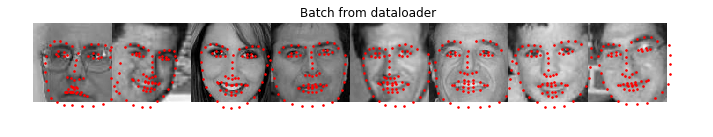

1


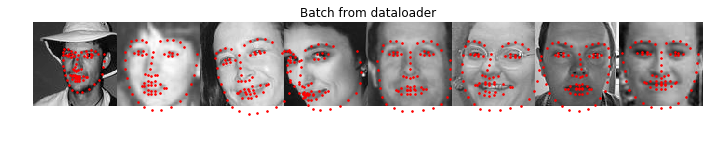

2


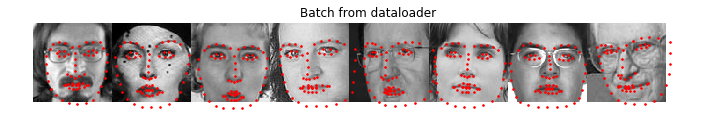

In [19]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch)
    plt.figure(figsize=(12,6))
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if( i_batch == 2):
        break

In [20]:
def apply_model(model, train, test, loss_fn=torch.nn.MSELoss(), Epoch=10, learning_rate=0.001):
    Loss_train = []
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.linear.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        L_train = []
        for sample_batched in train:
            X = batch_gray_to_rgb(sample_batched['image'].unsqueeze(1)).float()
            y = sample_batched['landmarks']
            y = y.view(y.size(0), -1).float()
            y_pred = model(Variable(X))
            loss = loss_fn(y_pred, Variable(y, requires_grad=False))
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_loss = sum(L_train)/len(L_train)
        print "epoch: %d/%d\nloss: %f" %(epoch+1, Epoch, mean_loss)
        Loss_train.append(mean_loss)
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend(['train'])
        plt.show()
    Scores = []
    for i_batch, sample_batched in enumerate(test):
        X = batch_gray_to_rgb(sample_batched['image'].unsqueeze(1)).float()
        y = sample_batched['landmarks']
        size = y.size()
        y = y.view(y.size(0), -1).float()
        y_predicted = model(Variable(X))
        Scores.append(mean_squared_error(y.numpy(), y_predicted.data.numpy()))

        sample_batched['landmarks'] = y_predicted.data.view(size)
        plt.figure(figsize=(12,6))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if( i_batch == 2):
            break
    print("MSE: %f" %(sum(Scores)/len(Scores)))
    return

In [21]:
def batch_gray_to_rgb(image_batch):
    channels = 3
    result = torch.Tensor(image_batch.size(0), channels, image_batch.size(2), image_batch.size(3))
    for i in xrange(result.size(1)):
        result[:, i, :, :] = image_batch
    return result

In [22]:
class Transfer_alex(nn.Module):
    def __init__(self, D_in, D_out):
        super(Transfer_alex, self).__init__()
        self.features = models.alexnet(pretrained=True).features
        for param in self.features.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        features = self.features.forward(x)
        return self.linear.forward(features.squeeze())

epoch: 1/10
loss: 137.289259
epoch: 2/10
loss: 32.021625
epoch: 3/10
loss: 27.417590
epoch: 4/10
loss: 25.426272
epoch: 5/10
loss: 24.352730
epoch: 6/10
loss: 23.456318
epoch: 7/10
loss: 23.003205
epoch: 8/10
loss: 22.265021
epoch: 9/10
loss: 21.963044
epoch: 10/10
loss: 21.576849


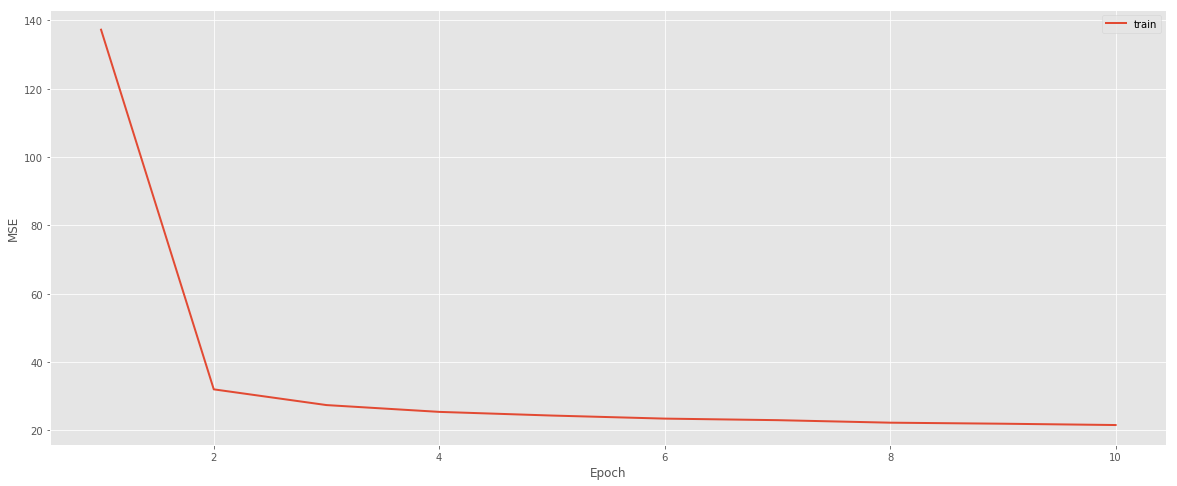

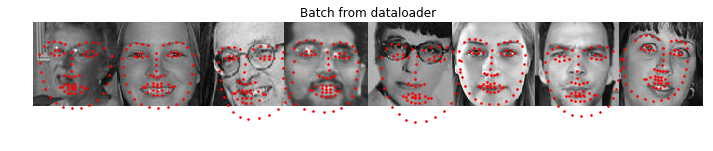

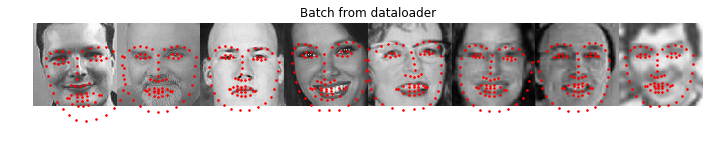

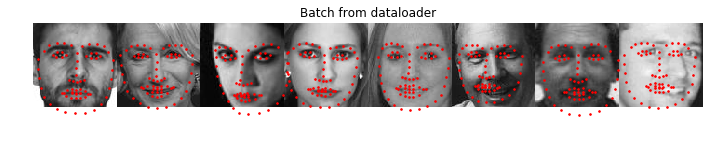

MSE: 29.895837


In [23]:
model = Transfer_alex(256, 136)
apply_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.01)

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

In [24]:
class Transfer_alex_extra(nn.Module):
    def __init__(self, D_in, D_out):
        super(Transfer_alex_extra, self).__init__()
        self.features = models.alexnet(pretrained=True).features
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        features = self.features(x)
        return self.linear(features.view(features.size(0), -1))

In [25]:
def apply_model_extra(model, train, test, Epoch=10, learning_rate=0.01):
    Loss_train = []
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        L_train = []
        for sample_batched in train:
            X = batch_gray_to_rgb(sample_batched['image'].unsqueeze(1)).float()
            y = sample_batched['landmarks']
            y = y.view(y.size(0), -1).float()
            y_pred = model(Variable(X))
            loss = loss_fn(y_pred, Variable(y, requires_grad=False))
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mean_loss = sum(L_train)/len(L_train)
        print "epoch: %d/%d\nloss: %f" %(epoch+1, Epoch, mean_loss)
        Loss_train.append(mean_loss)
    axis_x = np.arange(1, len(Loss_train) + 1)
    axis_y1 = np.array(Loss_train)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend(['train'])
        plt.show()
    Scores = []
    for i_batch, sample_batched in enumerate(test):
        X = batch_gray_to_rgb(sample_batched['image'].unsqueeze(1)).float()
        y = sample_batched['landmarks']
        size = y.size()
        y = y.view(y.size(0), -1).float()
        y_predicted = model(Variable(X))
        Scores.append(mean_squared_error(y.numpy(), y_predicted.data.numpy()))

        sample_batched['landmarks'] = y_predicted.data.view(size)
        plt.figure(figsize=(12,6))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if( i_batch == 2):
            break
    print("MSE: %f" %(sum(Scores)/len(Scores)))
    return

epoch: 1/20
loss: 45.781766
epoch: 2/20
loss: 14.975937
epoch: 3/20
loss: 9.035639
epoch: 4/20
loss: 8.234832
epoch: 5/20
loss: 7.714588
epoch: 6/20
loss: 6.724998
epoch: 7/20
loss: 6.358738
epoch: 8/20
loss: 6.530070
epoch: 9/20
loss: 5.766816
epoch: 10/20
loss: 6.119920
epoch: 11/20
loss: 5.722705
epoch: 12/20
loss: 5.138823
epoch: 13/20
loss: 5.010869
epoch: 14/20
loss: 4.884665
epoch: 15/20
loss: 5.437264
epoch: 16/20
loss: 4.666912
epoch: 17/20
loss: 4.791070
epoch: 18/20
loss: 4.606370
epoch: 19/20
loss: 4.583227
epoch: 20/20
loss: 4.159735


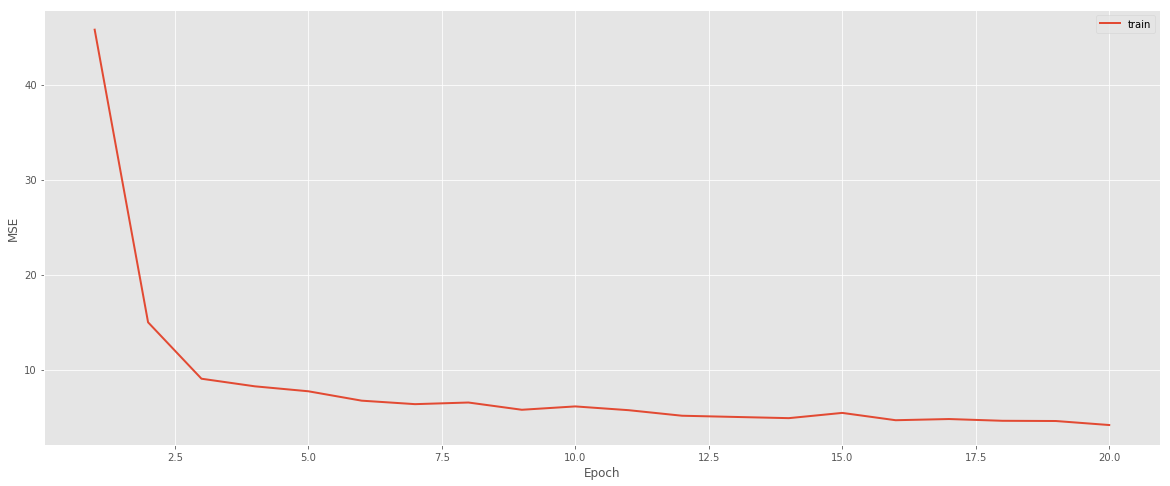

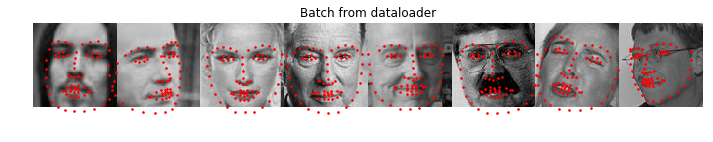

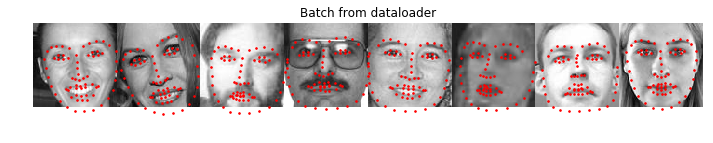

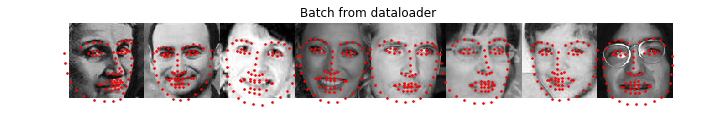

MSE: 4.557597


In [29]:
model = Transfer_alex_extra(256, 136)
apply_model_extra(model, train_loader, test_loader, Epoch=20, learning_rate=0.001)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: